In [1]:
import os
from spacy.vectors import Vectors
import numpy as np
import matplotlib.pyplot as plt

# Code

In [2]:
def get_file_size(filepath):
    statinfo = os.stat(filepath)
    size_mb = statinfo.st_size / 1024 / 1024
    return size_mb

In [3]:
class My_vec():
    
    def __init__(self, filepath):
        self.filepath = filepath
        with open(self.filepath, 'rb') as file_:
            header = file_.readline()
            nr_row, nr_dim = header.split()
        self.nr_row = int(nr_row)
        self.nr_dim = int(nr_dim)
     
    @property
    def size(self):       
        return get_file_size(self.filepath)
        
    def _get_key(self, line):
        line = line.rstrip().decode('utf8')
        pieces = line.rsplit(' ', self.nr_dim)
        return pieces[0]
    
    def _get_vector(self, line):
        line = line.rstrip().decode('utf8')
        pieces = line.rsplit(' ', self.nr_dim)
        vec = np.asarray(list(map(float, pieces[1:])), dtype='f')   
        return vec
        
    def keys(self, size=None):
        with open(self.filepath, 'rb') as file_:
            file_.readline() #first line
            words = [self._get_key(line) for count, line in enumerate(file_, 1)
                     if size is None or count <= size]
        return words
    
    def vectors(self, size=None):
        with open(self.filepath, 'rb') as file_:
            file_.readline() #first line
            vectors = [self._get_vector(line) for count, line in enumerate(file_, 1)
                     if size is None or count <= size]
        vectors = np.array(vectors)
        return vectors
    
    def get_first_n(self, n):
        lines = [""] * n
        with open(self.filepath, 'rb') as file_:
            file_.readline()
            for count, line in enumerate(file_):    
                if count >= n:
                    break
                lines[count] = line
        return lines


In [4]:
def get_ints_sizes(for_cutting, ref, n=100):
    ref_s = set(ref)
    sizes = np.linspace(len(ref), len(for_cutting), n)
    sizes = list(map(int, sizes))
    ints_s = [len(set(for_cutting[:s]) & ref_s) for s in sizes]
    ints_s = [s/len(ref) for s in ints_s]
    sizes = [s/1000 for s in sizes]
    return ints_s, sizes

# Consts

In [5]:
FASTTEXT_PATH = '../data/vectors/cc.pl.300.vec'
WORD2VEC_PATH = '../data/vectors_300.txt'
NEW_VEC_TXT = '../data/vectors/fasttext.txt'
NEW_VEC_BIN = '../data/vectors/fasttext_spacy'

# Compare vectors

In [6]:
fst = My_vec(FASTTEXT_PATH)
w2v = My_vec(WORD2VEC_PATH)
fst_keys = fst.keys()
w2v_keys = w2v.keys()

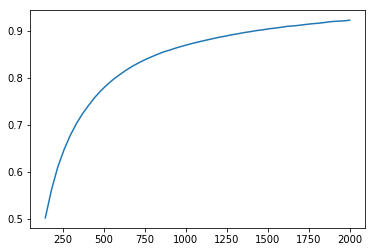

In [7]:
ints_s, sizes = get_ints_sizes(fst_keys, w2v_keys,50)
plt.plot(sizes, ints_s)

In [8]:
CHOSEN_SIZE = 700000
# get chosen vectors
fst_short_k = fst_keys[:CHOSEN_SIZE]
fst_short_v = fst.vectors(CHOSEN_SIZE)

assert len(fst_short_k) == len(fst_short_v) and len(fst_short_k) == CHOSEN_SIZE

new_inter = set(fst_short_k) & set(w2v_keys)
print("With CHOSEN_SIZE={}, we cover {:.1f}% of words from nkjp".format(CHOSEN_SIZE, len(new_inter)/len(w2v_keys)*100))

With CHOSEN_SIZE=700000, we cover 82.9% of words from nkjp


Uncomment cells below to prepare files

In [9]:
# fst_spacy = Vectors(data=fst_short_v, keys=fst_short_k)
# fst_spacy.to_disk(NEW_VEC_BIN)
# s = get_file_size(os.path.join(NEW_VEC_BIN, 'vectors'))
# print("Chosen fasttexts in binary format weight {} MB".format(round(s)))

Chosen fasttexts in binary format weight 1602 MB


In [10]:
# chosen_lines = fst.get_first_n(CHOSEN_SIZE)
# with open(NEW_VEC_TXT, 'wb') as f:
#     f.write(bytes("{} {}\n".format(CHOSEN_SIZE, fst.nr_dim), 'utf-8'))
#     f.writelines(chosen_lines)
# s = get_file_size(NEW_VEC_TXT)
# print("Chosen fasttexts in txt format weight {} MB".format(round(s)))

Chosen fasttexts in txt format weight 1511 MB


## Summary
Intersection between chosen fasttext subset and nkjp is sufficient.
We have to take in account the size of vectors. They are already very heavy. Probably packaged models compress these vectors. When we find out we should try to enlagre the number of vectors.